### GTSRB Traffic Sign Recognition - Part III

### CODE ONLY, For a detailed report, please refer to the GTSRB Final Report Part III

#### by Sean Sungil Kim

In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
# importing necessary modules
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import time
import warnings
warnings.filterwarnings("ignore")

# custom python scripts
import GTSRB_sungil           # preprocessing
import ConvNet_sungil         # ConvNet modeling

### Preprocessing

In [3]:
# reading the GTSRB data utilizing the custom python script
# grayscaled
num_classes = 43
data_GTSRB, data_class, labels = GTSRB_sungil.load_data(num_classes)
gray_GTSRB = GTSRB_sungil.gray_convrt(data_GTSRB)

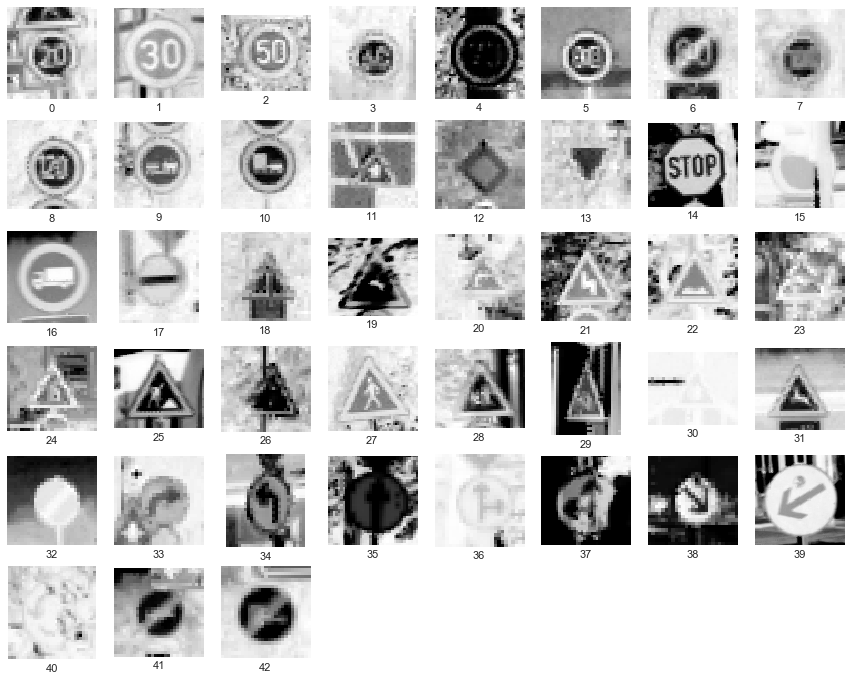

In [4]:
# one image example from each class, pre grayscale and downsizing
plt.figure(figsize = (15, 12))
for i in range(num_classes):
    plt.subplot(6, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(gray_GTSRB[data_class.tolist().index([i])], cmap = plt.cm.binary)
    plt.xlabel(i)
plt.show()

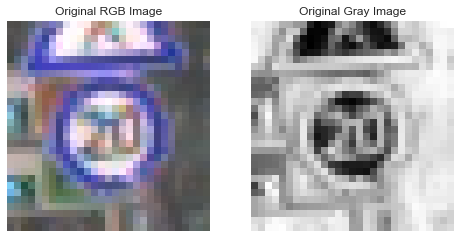

In [5]:
# original and post grayscale comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.show()

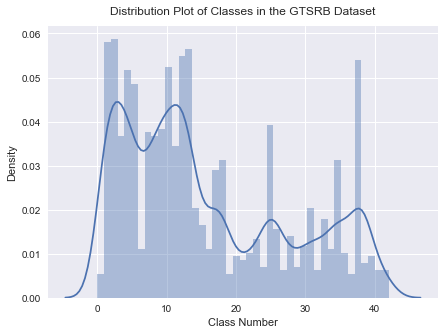

Total 39209 images in the GTSRB dataset
Total 39209 classes in the GTSRB class


In [6]:
# original class distribution
fig = plt.figure(figsize = (7, 5))
sns.distplot(data_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the GTSRB Dataset', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

# length of the data
print('Total %i images in the GTSRB dataset' % len(data_GTSRB))
print('Total %i classes in the GTSRB class' % len(data_class))

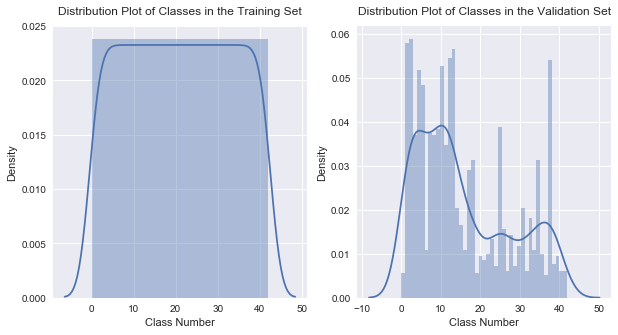

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [7]:
# resizing
resize_data = GTSRB_sungil.resize_all(gray_GTSRB, size = (28, 28))

# normalizing data, RGB/grayscale images are out of 255
norm_resized = resize_data / 255.0

# reshaping to be suitable for keras and tensorflow
nn_reshaped = GTSRB_sungil.nn_reshape(norm_resized)

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
x_train, x_val, y_class, y_val = train_test_split(nn_reshaped, data_class,\
                                                  stratify = data_class, test_size = 0.055)

# random under-sampling
und_train, und_class = GTSRB_sungil.under_sample(x_train, y_class)

# converting a class vector to binary class matrix
y_class_bin = keras.utils.to_categorical(und_class, num_classes)
y_val_bin = keras.utils.to_categorical(y_val, num_classes)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(y_val, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_train) + len(x_val)
print('Total of %i images in the training data' % len(und_train))
print('Total of %i images in the validation data' % len(x_val))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_train)/tot_len*100, len(x_val)/tot_len*100))

### Exploring with ConvNet Architectures

#### Small (Conv-Pool-Dropout)

In [8]:
model1 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model1.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

lr_finder1 = ConvNet_sungil.lr_finder(model1)
lr_finder1.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 27s 3ms/step - loss: 3.6791 - acc: 0.0600
Epoch 2/10
8514/8514 [==============================] - 19s 2ms/step - loss: 3.1447 - acc: 0.2350
Epoch 3/10
8514/8514 [==============================] - 21s 2ms/step - loss: 1.9804 - acc: 0.5040
Epoch 4/10
8514/8514 [==============================] - 27s 3ms/step - loss: 1.0224 - acc: 0.7284
Epoch 5/10
8514/8514 [==============================] - 26s 3ms/step - loss: 0.7529 - acc: 0.7956
Epoch 6/10
8514/8514 [==============================] - 26s 3ms/step - loss: 1.2308 - acc: 0.6822
Epoch 7/10
2944/8514 [=========>....................] - ETA: 16s - loss: 1.5313 - acc: 0.6162

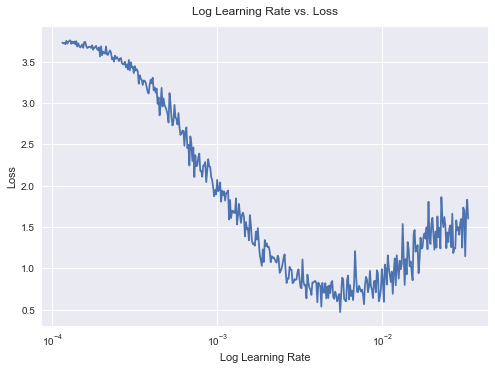

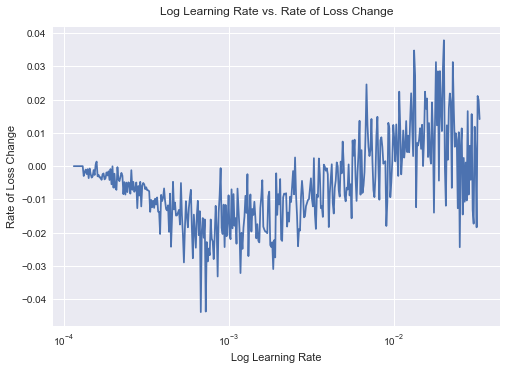

In [9]:
lr_finder1.plot_loss()
lr_finder1.plot_loss_change(sma = 20)

In [12]:
K.set_value(model1.optimizer.lr, 3*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
mc = keras.callbacks.ModelCheckpoint('best_model1.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history1 = model1.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 21s 3ms/step - loss: 3.0861 - acc: 0.2104 - val_loss: 1.9621 - val_acc: 0.5067

Epoch 00001: val_acc improved from -inf to 0.50672, saving model to best_model1.h5
Epoch 2/200
8514/8514 [==============================] - 25s 3ms/step - loss: 1.3733 - acc: 0.6213 - val_loss: 0.9250 - val_acc: 0.7937

Epoch 00002: val_acc improved from 0.50672 to 0.79369, saving model to best_model1.h5
Epoch 3/200
8514/8514 [==============================] - 24s 3ms/step - loss: 0.7594 - acc: 0.7891 - val_loss: 0.6094 - val_acc: 0.8674

Epoch 00003: val_acc improved from 0.79369 to 0.86741, saving model to best_model1.h5
Epoch 4/200
8514/8514 [==============================] - 20s 2ms/step - loss: 0.5436 - acc: 0.8513 - val_loss: 0.5057 - val_acc: 0.8688

Epoch 00004: val_acc improved from 0.86741 to 0.86880, saving model to best_model1.h5
Epoch 5/200
8514/8514 [==============================] - 25s 3m

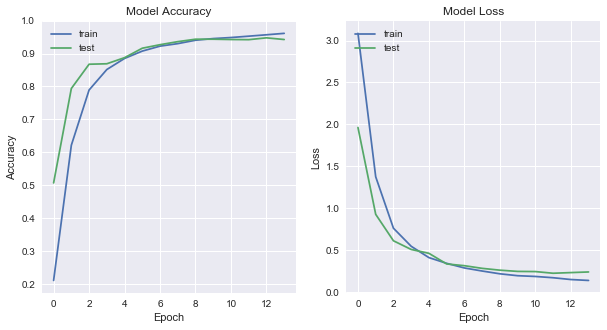

In [13]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['acc']), plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss']), plt.plot(history1.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Conv-Pool-Dropout)

In [14]:
model2 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder2 = ConvNet_sungil.lr_finder(model2)
lr_finder2.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 51s 6ms/step - loss: 3.6778 - acc: 0.0648
Epoch 2/10
8514/8514 [==============================] - 49s 6ms/step - loss: 2.8710 - acc: 0.2930
Epoch 3/10
8514/8514 [==============================] - 53s 6ms/step - loss: 1.2883 - acc: 0.6553
Epoch 4/10
8514/8514 [==============================] - 52s 6ms/step - loss: 0.7011 - acc: 0.8067
Epoch 5/10
8514/8514 [==============================] - 39s 5ms/step - loss: 0.4663 - acc: 0.8632
Epoch 6/10
4352/8514 [==============>...............] - ETA: 21s - loss: 0.4813 - acc: 0.8603

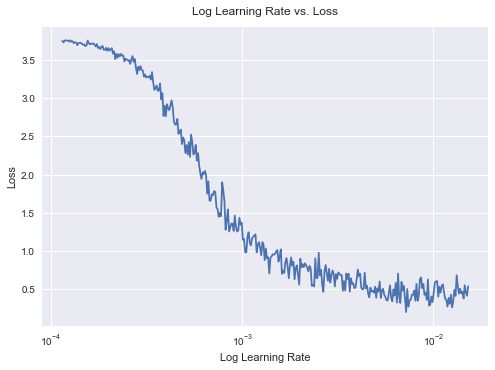

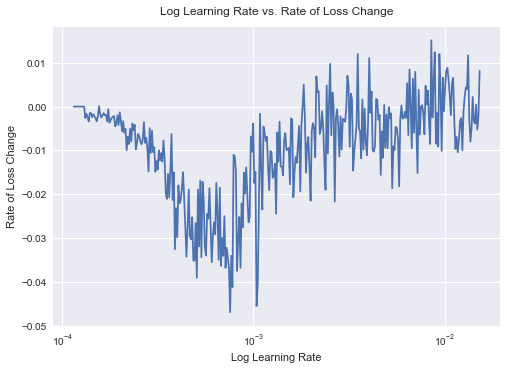

In [15]:
lr_finder2.plot_loss()
lr_finder2.plot_loss_change(sma = 20)

In [16]:
K.set_value(model2.optimizer.lr, 10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
mc = keras.callbacks.ModelCheckpoint('best_model2.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history2 = model2.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 50s 6ms/step - loss: 3.5065 - acc: 0.1124 - val_loss: 2.8882 - val_acc: 0.2452

Epoch 00001: val_acc improved from -inf to 0.24525, saving model to best_model2.h5
Epoch 2/200
8514/8514 [==============================] - 49s 6ms/step - loss: 1.9201 - acc: 0.4834 - val_loss: 1.1180 - val_acc: 0.7316

Epoch 00002: val_acc improved from 0.24525 to 0.73157, saving model to best_model2.h5
Epoch 3/200
8514/8514 [==============================] - 51s 6ms/step - loss: 0.8928 - acc: 0.7568 - val_loss: 0.6726 - val_acc: 0.8465

Epoch 00003: val_acc improved from 0.73157 to 0.84655, saving model to best_model2.h5
Epoch 4/200
8514/8514 [==============================] - 56s 7ms/step - loss: 0.5350 - acc: 0.8517 - val_loss: 0.4400 - val_acc: 0.8915

Epoch 00004: val_acc improved from 0.84655 to 0.89152, saving model to best_model2.h5
Epoch 5/200
8514/8514 [==============================] - 49s 6m

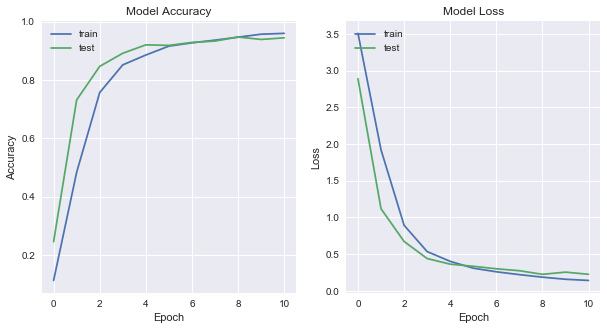

In [17]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['acc']), plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss']), plt.plot(history2.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Pool-Conv-Pool-Dropout)

In [18]:
model3 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder3 = ConvNet_sungil.lr_finder(model3)
lr_finder3.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 17s 2ms/step - loss: 3.7481 - acc: 0.0295
Epoch 2/10
8514/8514 [==============================] - 17s 2ms/step - loss: 3.6063 - acc: 0.0903
Epoch 3/10
8514/8514 [==============================] - 15s 2ms/step - loss: 2.4857 - acc: 0.3490: 1s - loss: 2.5364 - acc: 0
Epoch 4/10
8514/8514 [==============================] - 14s 2ms/step - loss: 1.2399 - acc: 0.6405: 11s - los
Epoch 5/10
8514/8514 [==============================] - 17s 2ms/step - loss: 0.8347 - acc: 0.7526
Epoch 6/10
8514/8514 [==============================] - 19s 2ms/step - loss: 0.8328 - acc: 0.7622
Epoch 7/10
2048/8514 [======>.......................] - ETA: 14s - loss: 1.2134 - acc: 0.6753

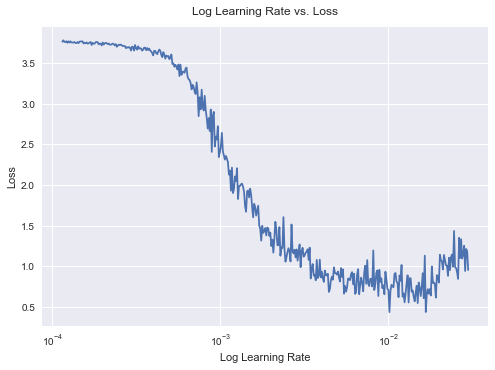

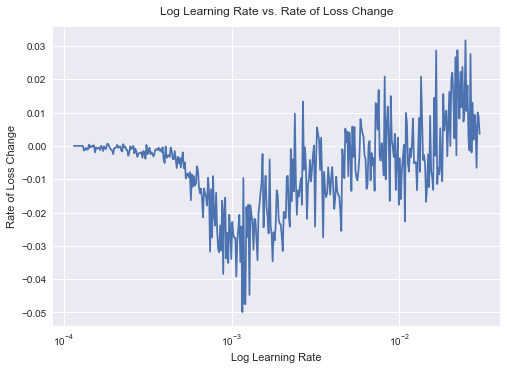

In [19]:
lr_finder3.plot_loss()
lr_finder3.plot_loss_change(sma = 20)

In [20]:
K.set_value(model3.optimizer.lr, 2*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
mc = keras.callbacks.ModelCheckpoint('best_model3.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history3 = model3.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 16s 2ms/step - loss: 3.6444 - acc: 0.0631 - val_loss: 3.3194 - val_acc: 0.1850

Epoch 00001: val_acc improved from -inf to 0.18498, saving model to best_model3.h5
Epoch 2/200
8514/8514 [==============================] - 18s 2ms/step - loss: 2.5903 - acc: 0.3187 - val_loss: 1.7396 - val_acc: 0.5647

Epoch 00002: val_acc improved from 0.18498 to 0.56467, saving model to best_model3.h5
Epoch 3/200
8514/8514 [==============================] - 18s 2ms/step - loss: 1.4959 - acc: 0.5625 - val_loss: 1.0373 - val_acc: 0.7506

Epoch 00003: val_acc improved from 0.56467 to 0.75058, saving model to best_model3.h5
Epoch 4/200
8514/8514 [==============================] - 15s 2ms/step - loss: 0.9969 - acc: 0.7041 - val_loss: 0.7544 - val_acc: 0.7840

Epoch 00004: val_acc improved from 0.75058 to 0.78396, saving model to best_model3.h5
Epoch 5/200
8514/8514 [==============================] - 25s 3m

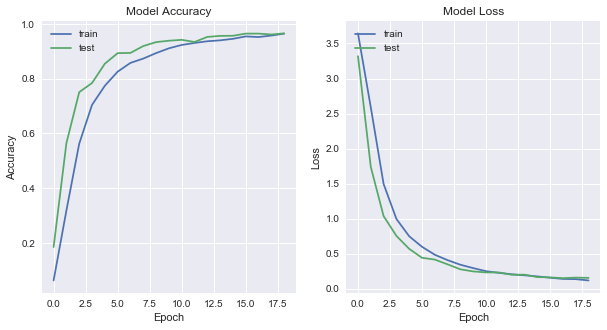

In [21]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['acc']), plt.plot(history3.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss']), plt.plot(history3.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Conv-Pool-Conv-Conv-Pool-Dropout)

In [22]:
model4 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder4 = ConvNet_sungil.lr_finder(model4)
lr_finder4.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 44s 5ms/step - loss: 3.7504 - acc: 0.0302
Epoch 2/10
8514/8514 [==============================] - 45s 5ms/step - loss: 3.2308 - acc: 0.1853
Epoch 3/10
8514/8514 [==============================] - 44s 5ms/step - loss: 1.5907 - acc: 0.5556
Epoch 4/10
8514/8514 [==============================] - 39s 5ms/step - loss: 0.7964 - acc: 0.7626
Epoch 5/10
8514/8514 [==============================] - 41s 5ms/step - loss: 0.5479 - acc: 0.8327
Epoch 6/10
7296/8514 [========================>.....] - ETA: 6s - loss: 0.6825 - acc: 0.8065

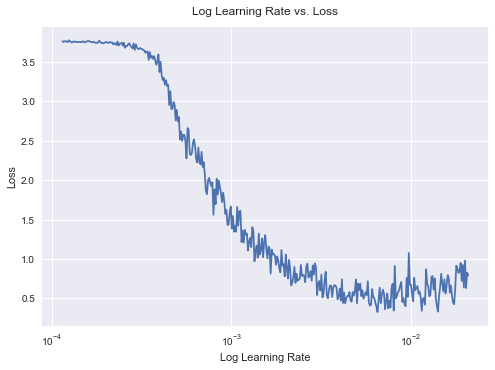

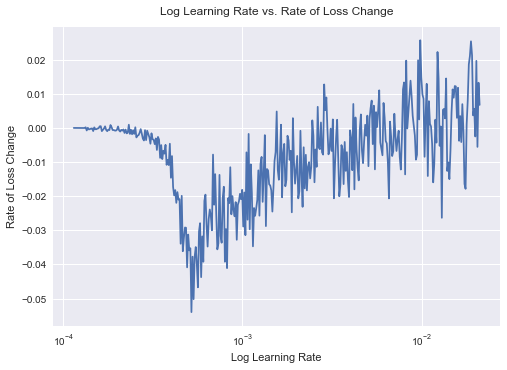

In [23]:
lr_finder4.plot_loss()
lr_finder4.plot_loss_change(sma = 20)

In [24]:
K.set_value(model4.optimizer.lr, 10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
mc = keras.callbacks.ModelCheckpoint('best_model4.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history4 = model4.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 43s 5ms/step - loss: 3.7524 - acc: 0.0280 - val_loss: 3.7322 - val_acc: 0.0468

Epoch 00001: val_acc improved from -inf to 0.04682, saving model to best_model4.h5
Epoch 2/200
8514/8514 [==============================] - 43s 5ms/step - loss: 3.5466 - acc: 0.1005 - val_loss: 2.8989 - val_acc: 0.2786

Epoch 00002: val_acc improved from 0.04682 to 0.27863, saving model to best_model4.h5
Epoch 3/200
8514/8514 [==============================] - 50s 6ms/step - loss: 2.0719 - acc: 0.4385 - val_loss: 1.2529 - val_acc: 0.6866

Epoch 00003: val_acc improved from 0.27863 to 0.68660, saving model to best_model4.h5
Epoch 4/200
8514/8514 [==============================] - 53s 6ms/step - loss: 1.1062 - acc: 0.6728 - val_loss: 0.6939 - val_acc: 0.8252

Epoch 00004: val_acc improved from 0.68660 to 0.82522, saving model to best_model4.h5
Epoch 5/200
8514/8514 [==============================] - 47s 6m

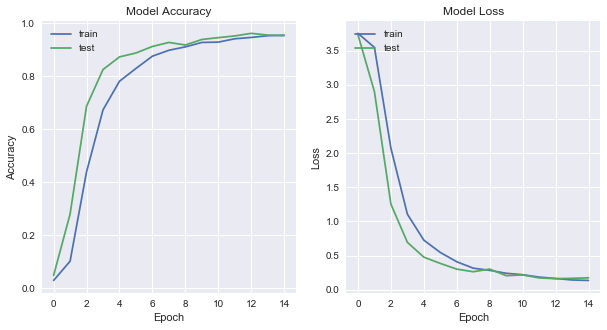

In [25]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['acc']), plt.plot(history4.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss']), plt.plot(history4.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium-Large (Conv-Pool-Conv-Pool-Conv-Pool-Dropout)

In [30]:
model5 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model5.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder5 = ConvNet_sungil.lr_finder(model5)
lr_finder5.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 15s 2ms/step - loss: 3.7596 - acc: 0.0264
Epoch 2/10
8514/8514 [==============================] - 13s 2ms/step - loss: 3.7374 - acc: 0.0322
Epoch 3/10
8514/8514 [==============================] - 16s 2ms/step - loss: 3.5078 - acc: 0.0853
Epoch 4/10
8514/8514 [==============================] - 15s 2ms/step - loss: 2.5601 - acc: 0.2629: 3s - loss: 2.67
Epoch 5/10
8514/8514 [==============================] - 15s 2ms/step - loss: 1.7809 - acc: 0.4580: 5s - 
Epoch 6/10
8514/8514 [==============================] - 17s 2ms/step - loss: 1.6343 - acc: 0.5195
Epoch 7/10
8514/8514 [==============================] - 16s 2ms/step - loss: 2.6064 - acc: 0.3195
Epoch 8/10
4736/8514 [===============>..............] - ETA: 5s - loss: 3.7288 - acc: 0.0629

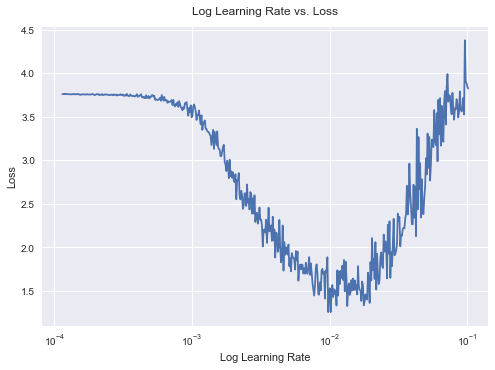

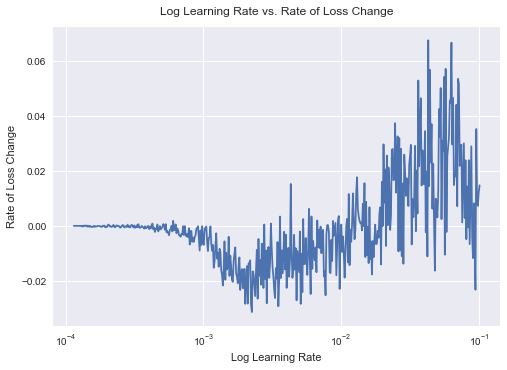

In [31]:
lr_finder5.plot_loss()
lr_finder5.plot_loss_change(sma = 20)

In [32]:
K.set_value(model5.optimizer.lr, 8*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model5.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history5 = model5.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 14s 2ms/step - loss: 3.7387 - acc: 0.0300 - val_loss: 3.6703 - val_acc: 0.0241

Epoch 00001: val_acc improved from -inf to 0.02411, saving model to best_model5.h5
Epoch 2/200
8514/8514 [==============================] - 15s 2ms/step - loss: 3.5468 - acc: 0.0617 - val_loss: 3.2460 - val_acc: 0.1066 loss: 3.6 - ETA: 2s - loss: 3.5953

Epoch 00002: val_acc improved from 0.02411 to 0.10663, saving model to best_model5.h5
Epoch 3/200
8514/8514 [==============================] - 20s 2ms/step - loss: 2.7734 - acc: 0.1981 - val_loss: 2.1408 - val_acc: 0.3941

Epoch 00003: val_acc improved from 0.10663 to 0.39407, saving model to best_model5.h5
Epoch 4/200
8514/8514 [==============================] - 19s 2ms/step - loss: 1.9469 - acc: 0.4043 - val_loss: 1.6589 - val_acc: 0.4998

Epoch 00004: val_acc improved from 0.39407 to 0.49977, saving model to best_model5.h5
Epoch 5/200
8514/8514 [=====

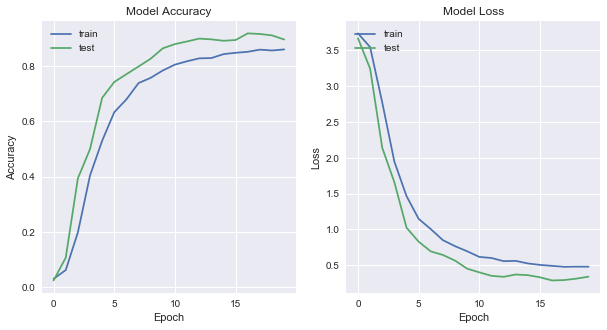

In [33]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history5.history['acc']), plt.plot(history5.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss']), plt.plot(history5.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium-Large (Conv-Pool-Conv-Conv-Pool-Conv-Pool-Dropout)

In [36]:
model6 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model6.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder6 = ConvNet_sungil.lr_finder(model6)
lr_finder6.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 17s 2ms/step - loss: 3.7598 - acc: 0.0242
Epoch 2/10
8514/8514 [==============================] - 17s 2ms/step - loss: 3.7286 - acc: 0.0350
Epoch 3/10
8514/8514 [==============================] - 19s 2ms/step - loss: 3.2246 - acc: 0.1370
Epoch 4/10
8514/8514 [==============================] - 17s 2ms/step - loss: 2.0667 - acc: 0.3903
Epoch 5/10
8514/8514 [==============================] - 22s 3ms/step - loss: 1.4062 - acc: 0.5630
Epoch 6/10
8514/8514 [==============================] - 16s 2ms/step - loss: 1.3476 - acc: 0.5989
Epoch 7/10
1024/8514 [==>...........................] - ETA: 13s - loss: 2.4247 - acc: 0.3779

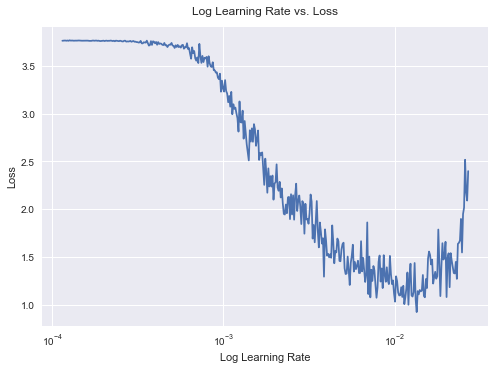

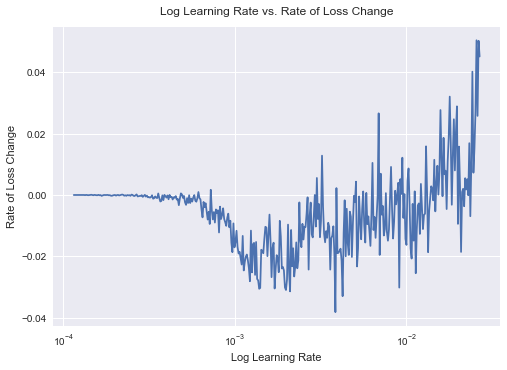

In [37]:
lr_finder6.plot_loss()
lr_finder6.plot_loss_change(sma = 20)

In [38]:
K.set_value(model6.optimizer.lr, 3*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model6.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history6 = model6.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 20s 2ms/step - loss: 3.7612 - acc: 0.0241 - val_loss: 3.7588 - val_acc: 0.0158

Epoch 00001: val_acc improved from -inf to 0.01576, saving model to best_model6.h5
Epoch 2/200
8514/8514 [==============================] - 23s 3ms/step - loss: 3.7529 - acc: 0.0308 - val_loss: 3.7370 - val_acc: 0.0325

Epoch 00002: val_acc improved from 0.01576 to 0.03245, saving model to best_model6.h5
Epoch 3/200
8514/8514 [==============================] - 19s 2ms/step - loss: 3.6740 - acc: 0.0521 - val_loss: 3.5921 - val_acc: 0.0640

Epoch 00003: val_acc improved from 0.03245 to 0.06398, saving model to best_model6.h5
Epoch 4/200
8514/8514 [==============================] - 19s 2ms/step - loss: 3.2706 - acc: 0.1320 - val_loss: 2.8127 - val_acc: 0.2170

Epoch 00004: val_acc improved from 0.06398 to 0.21697, saving model to best_model6.h5
Epoch 5/200
8514/8514 [==============================] - 25s 3m

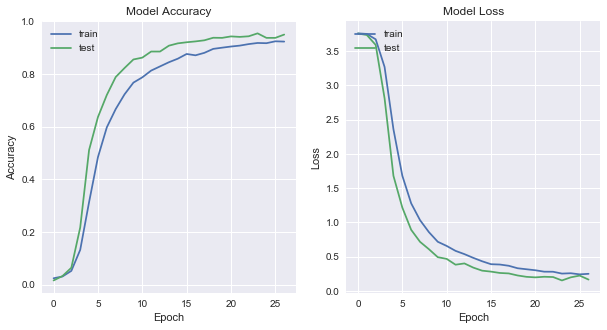

In [39]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history6.history['acc']), plt.plot(history6.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss']), plt.plot(history6.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Model Performance Comparisons

In [46]:
# model performance scores
saved_model1 = keras.models.load_model('best_model1.h5')
saved_model2 = keras.models.load_model('best_model2.h5')
saved_model3 = keras.models.load_model('best_model3.h5')
saved_model4 = keras.models.load_model('best_model4.h5')
saved_model5 = keras.models.load_model('best_model5.h5')
saved_model6 = keras.models.load_model('best_model6.h5')

y_prob1 = saved_model1.predict(x_val)
y_prob2 = saved_model2.predict(x_val)
y_prob3 = saved_model3.predict(x_val)
y_prob4 = saved_model4.predict(x_val)
y_prob5 = saved_model5.predict(x_val)
y_prob6 = saved_model6.predict(x_val)

cls_pred1 = y_prob1.argmax(axis = -1)
cls_pred2 = y_prob2.argmax(axis = -1)
cls_pred3 = y_prob3.argmax(axis = -1)
cls_pred4 = y_prob4.argmax(axis = -1)
cls_pred5 = y_prob5.argmax(axis = -1)
cls_pred6 = y_prob6.argmax(axis = -1)

precision1, recall1, fbeta_score1, support1 = precision_recall_fscore_support(y_val, cls_pred1, average = 'weighted')
precision2, recall2, fbeta_score2, support2 = precision_recall_fscore_support(y_val, cls_pred2, average = 'weighted')
precision3, recall3, fbeta_score3, support3 = precision_recall_fscore_support(y_val, cls_pred3, average = 'weighted')
precision4, recall4, fbeta_score4, support4 = precision_recall_fscore_support(y_val, cls_pred4, average = 'weighted')
precision5, recall5, fbeta_score5, support5 = precision_recall_fscore_support(y_val, cls_pred5, average = 'weighted')
precision6, recall6, fbeta_score6, support6 = precision_recall_fscore_support(y_val, cls_pred6, average = 'weighted')

model_List = ['model1', 'model2', 'model3', 'model4', 'model5', 'model6']
precision_List = [precision1, precision2, precision3, precision4, precision5, precision6]
recall_List = [recall1, recall2, recall3, recall4, recall5, recall6]
fscore_List = [fbeta_score1, fbeta_score2, fbeta_score3, fbeta_score4, fbeta_score5, fbeta_score6]

In [47]:
# final results table
final_results = pd.DataFrame({'Models': model_List, 'Precision Score': precision_List,\
                              'Recall Score': recall_List, 'F-Score': fscore_List}).set_index('Models')
final_results

,Precision Score,Recall Score,F-Score
Models,,,
model1,0.950634,0.947612,0.947405
model2,0.947694,0.947149,0.947005
model3,0.967325,0.965229,0.965499
model4,0.962857,0.961984,0.961951
model5,0.924291,0.919332,0.918841
model6,0.956079,0.954567,0.954603


### Final CNN Model

CNN classification report: 

               precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.96      0.97      0.96       122
           2       0.98      0.95      0.96       124
           3       0.83      0.92      0.87        78
           4       0.97      0.94      0.96       109
           5       0.98      0.83      0.90       102
           6       0.96      1.00      0.98        23
           7       0.94      0.95      0.94        79
           8       0.89      0.96      0.93        78
           9       0.99      0.96      0.97        81
          10       0.99      0.96      0.98       111
          11       1.00      0.99      0.99        73
          12       0.99      0.97      0.98       115
          13       1.00      1.00      1.00       119
          14       1.00      1.00      1.00        43
          15       0.88      1.00      0.93        35
          16       1.00      1.00      1.00        

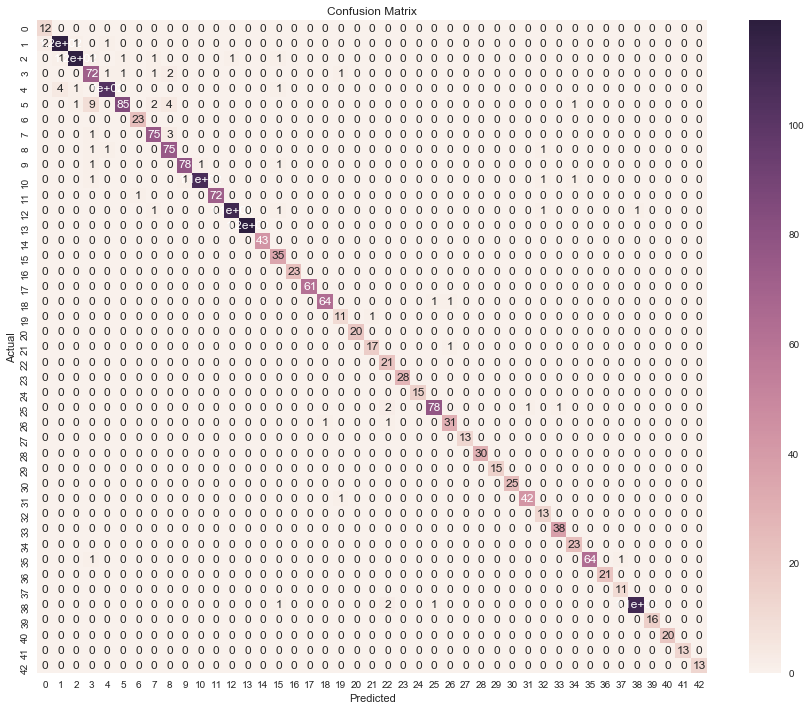

In [48]:
# classification report
print("CNN classification report:", "\n\n", classification_report(y_val, cls_pred3))

# accuracy confusion matrix
cm = confusion_matrix(y_val, cls_pred3)
plt.figure(figsize = (15, 12))
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

### Final 3 Models

| Classifiers | Precision | Recall | F-Score |
| --- | --- | --- | --- |
| CNN with the Architecture of Conv-Pool-Conv-Pool-Dropout (model3) | 0.967325 | 0.965229 | 0.965499 |
| Thresheld + Feature Selected (Wrapper-based) Random Forest Classifier from Part II | 0.924908 | 0.918869 | 0.918973 |
| Thresheld + Feature Selected (Wrapper-based) Support Vector Machine Classifier from Part II | 0.923204 | 0.919796 | 0.920249 |
